# CSE527 Homework 4
**Due date: 23:59 on Nov. 5, 2019 (Thuesday)**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Description
---
This project is an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for scene recognition using [PyTorch](http://pytorch.org). You can visualize the
structure of the network with [mNeuron] (http://vision03.csail.mit.edu/cnn_art/index.html)

Remember Homework 3: Scene recognition with bag of words. You worked hard to design a bag of features representations that achieved 60% to 70% accuracy (most likely) on 16-way scene classification. We're going to attack the same task with deep learning and get higher accuracy. Training from scratch won't work quite as well as homework 3 due to the insufficient amount of data, fine-tuning an existing network will work much better than homework 3.

In Problem 1 of the project you will train a deep convolutional network from scratch to recognize scenes. The starter codes gives you methods to load data and display them. You will need to define a simple network architecture and add jittering, normalization, and regularization to increase recognition accuracy to 50, 60, or perhaps 70%. Unfortunately, we only have 2,400 training examples so it doesn't seem possible to train a network from scratch which outperforms hand-crafted features

For Problem 2 you will instead fine-tune a pre-trained deep network to achieve about 85% accuracy on the task. We will use the pretrained AlexNet network which was not trained to recognize scenes at all. 

These two approaches represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do), and if you cannot then instead fine-tune a pre-trained network.

There are 2 problems in this homework with a total of 110 points including 10 bonus points. Be sure to read **Submission Guidelines** below. They are important. For the problems requiring text descriptions, you might want to add a markdown block for that.

## Dataset
---
Save the [dataset(click me)](https://drive.google.com/open?id=1NWC3TMsXSWN2TeoYMCjhf2N1b-WRDh-M) into your working folder in your Google Drive for this homework. <br>
Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.
**Do not upload** the data subfolder before submitting on blackboard due to size limit. There should be only one .ipynb file under your root folder Surname_Givenname_SBUID.

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.


## Starter Code
---
In the starter code, you are provided with a function that loads data into minibatches for training and testing in PyTorch.

In [0]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

# PyTorch libraries and modules
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

import pickle
import time

In [0]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


'/content'

In [0]:
# Set your working directory (in your google drive)
# Note that 'gdrive/My Drive/Y2019Fall/CSE-527-Intro-To-Computer-Vision/hw4' is just an example, 
#   change it to your specific homework directory.
cd '/content/gdrive/My Drive/Y2019Fall/CSE-527-Intro-To-Computer-Vision/Paratkar_Shreyash_112673930_hw4'

/content/gdrive/My Drive/Y2019Fall/CSE-527-Intro-To-Computer-Vision/Paratkar_Shreyash_112673930_hw4


In [0]:
%pwd
%ls -lrt

total 2007647
-rw------- 1 root root   39371054 Nov  4 01:33 trainloader_small.pkl
-rw------- 1 root root    6561642 Nov  4 01:33 testloader_small.pkl
-rw------- 1 root root   78742766 Nov  4 06:28 trainloader_small_augmented.pkl
-rw------- 1 root root   78742766 Nov  4 06:37 trainloader_small_augmented_normalized.pkl
-rw------- 1 root root  118113902 Nov  4 08:59 trainloader_small_augmented_normalized_rotated.pkl
-rw------- 1 root root 1445118158 Nov  4 09:27 trainloader_large.pkl
-rw------- 1 root root  240852826 Nov  4 09:30 testloader_large.pkl
-rw------- 1 root root   39336214 Nov  5 02:08 alexnet_output.pkl
-rw------- 1 root root    6556058 Nov  5 02:08 alexnet_output_test.pkl
-rw------- 1 root root    2346954 Nov  5 18:16 Paratkar_Shreyash_112673930_hw4.pdf
-rw------- 1 root root      85678 Nov  6 00:14 Paratkar_Shreyash_112673930_hw4.ipynb


In [0]:
# ==========================================
#    Load Training Data and Testing Data
# ==========================================
class_names = [name[111:] for name in glob.glob('/content/gdrive/My Drive/Y2019Fall/CSE-527-Intro-To-Computer-Vision/Paratkar_Shreyash_112673930_hw3/data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)
n_train_samples = 150
n_test_samples = 50


def img_norm(img):
  #
  # Write your code here
  # normalize img pixels to [-1, 1]
  #
  img = img.astype(float)
  img = cv2.normalize(img, None, alpha=-1, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  return img

def load_dataset(path, img_size, num_per_class=-1, batch_num=1, shuffle=False, augment=False, is_color=False,
                rotate_90=False, zero_centered=False):
    
    data = []
    labels = []
    
    if is_color:
        channel_num = 3
    else:
        channel_num = 1
        
    # read images and resizing
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        if augment == True:
          labels.extend([id]*len(img_path_class))
        if rotate_90 == True:
          labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)
            
            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
            if is_color:
                img = np.transpose(img, [2, 0, 1])
            
            # norm pixel values to [-1, 1]
            data.append(img_norm(img))
            if augment == True:
              data.append(np.fliplr(img_norm(img)))
            if rotate_90 == True:
              data.append(np.rot90(img_norm(img)))
            
    #
    # Write your Data Augmentation code here
    # mirroring
    #
            
    #
    # Write your Data Normalization code here
    # norm data to zero-centered
    #
    
    if zero_centered == True:
      data = data - np.mean(data)
     
    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        random.shuffle(bundle)
        data, labels = zip(*bundle)
    
    # divide data into minibatches of TorchTensors
    if batch_num > 1:
        batch_data = []
        batch_labels = []
        
        print(len(data))
        print(batch_num)
        
        for i in range(int(len(data) / batch_num)):
            minibatch_d = data[i*batch_num: (i+1)*batch_num]
            minibatch_d = np.reshape(minibatch_d, (batch_num, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_num: (i+1)*batch_num]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels 
    
    return zip(batch_data, batch_labels)

class_names: {0: 'Forest', 1: 'Industrial', 2: 'Flower', 3: 'Coast', 4: 'InsideCity', 5: 'Office', 6: 'Bedroom', 7: 'Highway', 8: 'Street', 9: 'TallBuilding', 10: 'LivingRoom', 11: 'Suburb', 12: 'OpenCountry', 13: 'Mountain', 14: 'Kitchen', 15: 'Store'} 


In [0]:
# load data into size (64, 64)
img_size = (64, 64)
batch_num = 50 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('/content/gdrive/My Drive/Y2019Fall/CSE-527-Intro-To-Computer-Vision/Paratkar_Shreyash_112673930_hw3/data/train/', img_size, batch_num=batch_num, shuffle=True, augment=False, zero_centered=False))
train_num = len(trainloader_small)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_small = list(load_dataset('/content/gdrive/My Drive/Y2019Fall/CSE-527-Intro-To-Computer-Vision/Paratkar_Shreyash_112673930_hw3/data/test/', img_size, num_per_class=50, batch_num=batch_num))
test_num = len(testloader_small)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
2400
50
Finish loading 48 minibatches(=50) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class:

In [0]:
file = open('trainloader_small.pkl','wb')
pickle.dump(trainloader_small, file)
file.close()
file = open('testloader_small.pkl','wb')
pickle.dump(testloader_small, file)
file.close()

In [0]:
# Reading from pickle files
file = open('trainloader_small.pkl', 'rb')
trainloader_small = pickle.load(file)
file.close()
file = open('testloader_small.pkl', 'rb')
testloader_small = pickle.load(file)
file.close()

In [0]:
type(trainloader_small[47][0][49])
# trainloader_small[47][0][49].shape -- image torch {47th batch , 0 for selecting image, 49th image in batch of 50}
# trainloader_small[47][1][49] -- label {47th batch , 1 for selecting label, 49th image in batch of 50}
# trainloader_small[batch_index][img/label][50 images][0]
# for i in range(48):
#   print(trainloader_small[i][0].shape, trainloader_small[i][1].shape)

torch.Tensor

Store


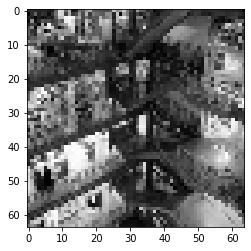

In [0]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small[0][0][11][0], trainloader_small[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

## Problem 1: Training a Network From Scratch
{Part 1: 35 points} Gone are the days of hand designed features. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective (in this case, 16-way classification accuracy). Instead of 70% accuracy we can now recognize scenes with... 25% accuracy. OK, that didn't work at all. Try to boost the accuracy by doing the following:

**Data Augmentation**: We don't have enough training data, let's augment the training data.
If you left-right flip (mirror) an image of a scene, it never changes categories. A kitchen doesn't become a forest when mirrored. This isn't true in all domains — a "d" becomes a "b" when mirrored, so you can't "jitter" digit recognition training data in the same way. But we can synthetically increase our amount of training data by left-right mirroring training images during the learning process.

After you implement mirroring, you should notice that your training error doesn't drop as quickly. That's actually a good thing, because it means the network isn't overfitting to the 2,400 original training images as much (because it sees 4,800 training images now, although they're not as good as 4,800 truly independent samples). Because the training and test errors fall more slowly, you may need more training epochs or you may try modifying the learning rate. You should see a roughly 10% increase in accuracy by adding mirroring. You are **required** to implement mirroring as data augmentation for this part.

You can try more elaborate forms of jittering -- zooming in a random amount, rotating a random amount, taking a random crop, etc. These are not required, you might want to try these in the bonus part.

**Data Normalization**: The images aren't zero-centered. One simple trick which can help a lot is to subtract the mean from every image. It would arguably be more proper to only compute the mean from the training images (since the test/validation images should be strictly held out) but it won't make much of a difference. After doing this you should see another 15% or so increase in accuracy. This part is **required**.

**Network Regularization**: Add dropout layer. If you train your network (especially for more than the default 30 epochs) you'll see that the training error can decrease to zero while the val top1 error hovers at 40% to 50%. The network has learned weights which can perfectly recognize the training data, but those weights don't generalize to held out test data. The best regularization would be more training data but we don't have that. Instead we will use dropout regularization.

What does dropout regularization do? It randomly turns off network connections at training time to fight overfitting. This prevents a unit in one layer from relying too strongly on a single unit in the previous layer. Dropout regularization can be interpreted as simultaneously training many "thinned" versions of your network. At test, all connections are restored which is analogous to taking an average prediction over all of the "thinned" networks. You can see a more complete discussion of dropout regularization in this [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

The dropout layer has only one free parameter — the dropout rate — the proportion of connections that are randomly deleted. The default of 0.5 should be fine. Insert a dropout layer between your convolutional layers. In particular, insert it directly before your last convolutional layer. Your test accuracy should increase by another 10%. Your train accuracy should decrease much more slowly. That's to be expected — you're making life much harder for the training algorithm by cutting out connections randomly. 

If you increase the number of training epochs (and maybe decrease the learning rate) you should be able to achieve around 50% test accuracy. In this part, you are **required** to add dropout layer to your network.

Please give detailed descriptions of your network layout in the following format:<br>
Data augmentation: [descriptions]<br>
Data normalization: [descriptions]<br>
Layer 1: [layer_type]: [Parameters]<br>
Layer 2: [layer_type]: [Parameters]<br>
...<br>
Then report the final accuracy on test set and time consumed for training and testing separately.

{Part 2: 15 points} Try **three techniques** taught in the class to increase the accuracy of your model. Such as increasing training data by randomly rotating training images, adding batch normalization, different activation functions (e.g., sigmoid) and model architecture modification. Note that too many layers can do you no good due to insufficient training data. Clearly describe your method and accuracy increase/decrease for each of the three techniques.

In [0]:
# ==========================================
#       Define Network Architecture
# ==========================================
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2),
        )
        self.linear_layers = Sequential(
            Linear(64 * 16 * 16, 1000),
            Linear(1000, 16)
        )
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

class Net_Dropout(Module):   
    def __init__(self):
        super(Net_Dropout, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(16 * 16 * 64, 1000)
        self.fc2 = nn.Linear(1000, 16)

    def forward(self, x):
      out = self.layer1(x)
      out = self.drop_out(out)
      out = self.layer2(out)
      out = out.reshape(out.size(0), -1)
      out = self.fc1(out)
      out = self.fc2(out)
      return out

class Net_Enhance1(Module):   
    def __init__(self):
        super(Net_Enhance1, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(16 * 16 * 64, 1000)
        self.fc2 = nn.Linear(1000, 16)

    def forward(self, x):
      out = self.layer1(x)
      out = self.drop_out(out)
      out = self.layer2(out)
      out = out.reshape(out.size(0), -1)
      out = self.fc1(out)
      out = self.fc2(out)
      return out

class Net_Enhance2(Module):   
    def __init__(self):
        super(Net_Enhance2, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(16 * 16 * 64, 1000)
        self.fc2 = nn.Linear(1000, 16)

    def forward(self, x):
      out = self.layer1(x)
      out = self.drop_out(out)
      out = self.layer2(out)
      out = out.reshape(out.size(0), -1)
      out = self.fc1(out)
      out = self.fc2(out)
      return out

def train(epoch, training_set, device, model, optimizer, criterion):
    for i in range(len(training_set)):
      x_train, y_train = Variable(training_set[i][0]).cuda(device), Variable(training_set[i][1]).cuda(device)
      output_train = model(x_train)
      loss_train = criterion(output_train, y_train)
      optimizer.zero_grad()
      loss_train.backward()
      optimizer.step()

def test(training_set, device, model):
  with torch.no_grad():
    total = 0
    correct = 0
    for i in range(8):
      outputs = model(Variable(training_set[i][0]).cuda(device))
      _, predicted = torch.max(outputs.data, 1)
      total += training_set[i][1].size(0)
      correct += (predicted == training_set[i][1].cuda(device)).sum().item()
    print('Test Accuracy of the model on test images: {} %'.format((correct / total) * 100))

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Net()
model.cuda(device)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()
n_epochs = 5
start_time = time.time()
for epoch in range(n_epochs):
    train(epoch, trainloader_small, device, model, optimizer, criterion)
print("Time taken for training: ", round(time.time() - start_time), "seconds")
start_time = time.time()
test(testloader_small, device, model)
print("Time taken for testing: ", round(time.time() - start_time), "seconds")

Time taken for training:  2 seconds
Test Accuracy of the model on test images: 24.5 %
Time taken for testing:  0 seconds


Test Accuracy acheived with the basic architecture and training size of **2400** images = **24.5%**

In [0]:
# ==========================================
#         Optimize/Train Network
# ==========================================
trainloader_small_augmented = list(load_dataset('/content/gdrive/My Drive/Y2019Fall/CSE-527-Intro-To-Computer-Vision/Paratkar_Shreyash_112673930_hw3/data/train/', img_size, batch_num=batch_num, shuffle=True, augment=True, zero_centered=False))
train_num_augmented = len(trainloader_small_augmented)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num_augmented, batch_num))
file = open('trainloader_small_augmented.pkl','wb')
pickle.dump(trainloader_small_augmented, file)
file.close()

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
4800
50
Finish loading 96 minibatches(=50) of training samples.


Data Augmented to contain **2400** more images which are the mirrored/laterally inverted versions of the original **2400** images, thereby giving us a final images set of **4800**.

In [0]:
file = open('trainloader_small_augmented.pkl', 'rb')
trainloader_small_augmented = pickle.load(file)
file.close()

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Net()
model.cuda(device)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()
start_time = time.time()
for epoch in range(n_epochs):
    train(epoch, trainloader_small_augmented, device, model, optimizer, criterion)
print("Time taken for training: ", round(time.time() - start_time), "seconds")
start_time = time.time()
test(testloader_small, device, model)
print("Time taken for testing: ", round(time.time() - start_time), "seconds")

Time taken for training:  5 seconds
Test Accuracy of the model on test images: 34.25 %
Time taken for testing:  0 seconds


The accuracy obtained after **Data Augmentation** = **34.25%**

In [0]:
trainloader_small_augmented_normalized = list(load_dataset('/content/gdrive/My Drive/Y2019Fall/CSE-527-Intro-To-Computer-Vision/Paratkar_Shreyash_112673930_hw3/data/train/', img_size, batch_num=batch_num, shuffle=True, augment=True, zero_centered=True))
train_num_augmented_normalized = len(trainloader_small_augmented_normalized)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num_augmented_normalized, batch_num))
file = open('trainloader_small_augmented_normalized.pkl','wb')
pickle.dump(trainloader_small_augmented_normalized, file)
file.close()

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
4800
50
Finish loading 96 minibatches(=50) of training samples.


Images are **zero-centered** by subtracting each pixel of each image by the mean of all the pixels in the dataset.

In [0]:
file = open('trainloader_small_augmented_normalized.pkl', 'rb')
trainloader_small_augmented_normalized = pickle.load(file)
file.close()

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Net()
model.cuda(device)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()
start_time = time.time()
for epoch in range(n_epochs):
    train(epoch, trainloader_small_augmented_normalized, device, model, optimizer, criterion)
print("Time taken for training: ", round(time.time() - start_time), "seconds")
start_time = time.time()
test(testloader_small, device, model)
print("Time taken for testing: ", round(time.time() - start_time), "seconds")

Time taken for training:  5 seconds
Test Accuracy of the model on test images: 41.25 %
Time taken for testing:  0 seconds


Model accuracy after **Data Normalization** = **41.25%**

In [0]:
model = Net_Dropout()
model.cuda(device)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()
start_time = time.time()
for epoch in range(20):
    train(epoch, trainloader_small_augmented_normalized, device, model, optimizer, criterion)
print("Time taken for training: ", round(time.time() - start_time), "seconds")
start_time = time.time()
test(testloader_small, device, model)
print("Time taken for testing: ", round(time.time() - start_time), "seconds")

Time taken for training:  19 seconds
Test Accuracy of the model on test images: 47.0 %
Time taken for testing:  0 seconds


A dropout layer is added before the 2nd convolutional layer, with a default droupout rate of **0.5**. Accuracy obtained after adding dropout = **47%**

**Data augmentation:** To increase the accuracy of the convolutional neural network, we augment the training dataset with the laterally inverted variants of the same original images, since the labels for these images would remain the same even if the orientation changes.

This augmentation gives us an accuracy of **34.25%**, which is a development on the original **24.5%**.

The time taken for training is 5 seconds while the testing gets completed in ~0 seconds.

**Data normalization:** To zero-center te images, the mean of the whole dataset's images, is subtracted from all the images, as the normalization step. This gives our model an accuracy of **41.25%** and takes about the same time for training and testing as the previous method, i.e. 5 seconds and ~0 seconds respectively.

The convolutional neural network defined for the basic test, data augmentation and data normalization involved the following layers.

**Layer 1:** Sequential layer: Consists of convolution + ReLU + pooling sequences.

i.) Conv2d nn.Module creates a set of convolutional filters : [1 input channel( grayscale image), 32 channels for first convolutional filter layer, kernel_size = 5, stride = 1, padding = 2]

ii.) A simple ReLU activation. 

iii.) Max pooling operation, pooling size = 2. To downsample by size of 2, we set the stride = 2 and padding = 0 -> 32 channels of 32 x 32 “images”.

**Layer 2:** Sequential layer: Consists of convolution + ReLU + pooling sequences.

i.) Conv2d nn.Module creates a set of convolutional filters : [32 input channel, 64 channels for second convolutional filter layer, kernel_size = 5, stride = 1, padding = 2]

ii.) A simple ReLU activation. 

iii.) Max pooling operation, pooling size = 2. To downsample by size of 2, we set the stride = 2 and padding = 0 -> 32 channels of 16 x 16 “images”.

**Layer 3:** Fully Connected Layer: The first layer will be of size 16 x 16 x 64 nodes.

**Layer 4:** Fully Connected Layer: first layer will connect to the second layer of 1000 nodes.

**Layer 1.5**: Dropout Layer: A dropout layer is inserted as mentioned in the question before the second convolutional layer.

The basic CNN gives an accuracy of **24.5%** with training time of **5** seconds.

The CNN implemented **with dropout** gives a testing accuracy of **47%** with training time of **19** seconds with **20 epochs**.

All the test accuracy values measured fluctuate above and below the above shown values.

In [0]:
# ==========================================
#            Evaluating Network
# ==========================================
model = Net_Enhance1()
model.cuda(device)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()
start_time = time.time()
for epoch in range(n_epochs):
    train(epoch, trainloader_small_augmented_normalized, device, model, optimizer, criterion)
print("Time taken for training: ", round(time.time() - start_time), "seconds")
start_time = time.time()
test(testloader_small, device, model)
print("Time taken for testing: ", round(time.time() - start_time), "seconds")

Time taken for training:  5 seconds
Test Accuracy of the model on test images: 32.5 %
Time taken for testing:  0 seconds


In [0]:
model = Net_Enhance2()
model.cuda(device)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()
start_time = time.time()
for epoch in range(n_epochs):
    train(epoch, trainloader_small_augmented_normalized, device, model, optimizer, criterion)
print("Time taken for training: ", round(time.time() - start_time), "seconds")
start_time = time.time()
test(testloader_small, device, model)
print("Time taken for testing: ", round(time.time() - start_time), "seconds")

Time taken for training:  5 seconds
Test Accuracy of the model on test images: 25.25 %
Time taken for testing:  0 seconds


In [0]:
img_size = (64, 64)
batch_num = 50
trainloader_small_augmented_normalized_rotated = list(load_dataset('/content/gdrive/My Drive/Y2019Fall/CSE-527-Intro-To-Computer-Vision/Paratkar_Shreyash_112673930_hw3/data/train/', img_size, batch_num=batch_num, shuffle=True, augment=True, zero_centered=True, rotate_90= True))
train_num_small_augmented_normalized_rotated = len(trainloader_small_augmented_normalized_rotated)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num_small_augmented_normalized_rotated, batch_num))
file = open('trainloader_small_augmented_normalized_rotated.pkl','wb')
pickle.dump(trainloader_small_augmented_normalized_rotated, file)
file.close()

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
7200
50
Finish loading 144 minibatches(=50) of training samples.


In [0]:
file = open('trainloader_small_augmented_normalized_rotated.pkl', 'rb')
trainloader_small_augmented_normalized_rotated = pickle.load(file)
file.close()

In [0]:
model = Net_Dropout()
model.cuda(device)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()
start_time = time.time()
for epoch in range(20):
    train(epoch, trainloader_small_augmented_normalized_rotated, device, model, optimizer, criterion)
print("Time taken for training: ", round(time.time() - start_time), "seconds")
start_time = time.time()
test(testloader_small, device, model)
print("Time taken for testing: ", round(time.time() - start_time), "seconds")

Time taken for training:  28 seconds
Test Accuracy of the model on test images: 48.75 %
Time taken for testing:  0 seconds


Three different techniques were tried to increase the accuracy of the baseline model which is trained for 3 epochs.

The first two techniques were passed augmented and normalized input sets of 4800 images.

1.) **Adding Batch Normalization**: A batch normalization element was added to the sequential layers of the basic CNN constructed. It was added twice after each of the convolution elements of the repective layers and was passed the number of output channels of the convolution elements as input (32 and 64 respectively).

This resulted in a test accuracy of **32.5%**, which is a decrease as compared to the **24.5%** obtained by the original network. Time taken for training: **5** seconds.

2.) **Using sigmoid activation function instead of ReLU**: Using the sigmoid activation function instead of ReLU gave a **0.75%** increase in test accuracy over the one obtained by using ReLU.

Test accuracy with sigmoid activation function = **25.25%**. Time taken for training: **5** seconds.

3.) For the third attempt at increasing accuracy, the previously increased training dataset of 4800 images was further augmented to contain 2400 more images which are the original images rotated by 90 degrees each.

This resulted in an increase of **24.25%** in test accuracy over the original model.

Test accuracy with sigmoid activation function = **48.75%**. Because the training data size is tripled, the training time required with 20 epochs is **28** seconds.

Resource referred:

1.) https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/

2.) https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/

## Problem 2: Fine Tuning a Pre-Trained Deep Network
{Part 1: 30 points} Our convolutional network to this point isn't "deep". Fortunately, the representations learned by deep convolutional networks is that they generalize surprisingly well to other recognition tasks. 

But how do we use an existing deep network for a new recognition task? Take for instance,  [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) network has 1000 units in the final layer corresponding to 1000 ImageNet categories.

**Strategy A**: One could use those 1000 activations as a feature in place of a hand crafted feature such as a bag-of-features representation. You would train a classifier (typically a linear SVM) in that 1000 dimensional feature space. However, those activations are clearly very object specific and may not generalize well to new recognition tasks. It is generally better to use the activations in slightly earlier layers of the network, e.g. the 4096 activations in the last 2nd fully-connected layer. You can often get away with sub-sampling those 4096 activations considerably, e.g. taking only the first 200 activations. 

**Strategy B**: *Fine-tune* an existing network. In this scenario you take an existing network, replace the final layer (or more) with random weights, and train the entire network again with images and ground truth labels for your recognition task. You are effectively treating the pre-trained deep network as a better initialization than the random weights used when training from scratch. When you don't have enough training data to train a complex network from scratch (e.g. with the 16 classes) this is an attractive option. Fine-tuning can work far better than Strategy A of taking the activations directly from an pre-trained CNN. For example, in [this paper](http://www.cc.gatech.edu/~hays/papers/deep_geo.pdf) from CVPR 2015, there wasn't enough data to train a deep network from scratch, but fine tuning led to 4 times higher accuracy than using off-the-shelf networks directly.

You are required to implement **Strategy B** to fine-tune a pre-trained **AlexNet** for this scene classification task. You should be able to achieve performance of 85% approximately. It takes roughly 35~40 minutes to train 20 epoches with AlexNet.

Please provide detailed descriptions of:<br>
(1) which layers of AlexNet have been replaced<br>
(2) the architecture of the new layers added including activation methods (same as problem 1)<br>
(3) the final accuracy on test set along with time consumption for both training and testing <br>

{Part 2: 20 points} Implement Strategy A where you use the activations of the pre-trained network as features to train one-vs-all SVMs for your scene classification task. Report the final accuracy on test set along with time consumption for both training and testing.

{Bonus: 10 points} Bonus will be given to those who fine-tune the [VGG network](https://pytorch.org/docs/stable/_modules/torchvision/models/vgg.html) [paper](https://arxiv.org/pdf/1409.1556.pdf) and compare performance with AlexNet. Explain why VGG performed better or worse.

**Hints**:
- Many pre-trained models are available in PyTorch at [here](http://pytorch.org/docs/master/torchvision/models.html).
- For fine-tuning pretrained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

In [0]:
# reload data with a larger size
img_size = (224, 224)
batch_num = 50 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('/content/gdrive/My Drive/Y2019Fall/CSE-527-Intro-To-Computer-Vision/Paratkar_Shreyash_112673930_hw3/data/train/', img_size, batch_num=batch_num, shuffle=True, augment=False, is_color=True, zero_centered=True))
file = open('trainloader_large.pkl','wb')
pickle.dump(trainloader_large, file)
file.close()
train_num = len(trainloader_large)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_large = list(load_dataset('/content/gdrive/My Drive/Y2019Fall/CSE-527-Intro-To-Computer-Vision/Paratkar_Shreyash_112673930_hw3/data/test/', img_size, num_per_class=50, batch_num=batch_num, is_color=True))
file = open('testloader_large.pkl','wb')
pickle.dump(testloader_large, file)
file.close()
test_num = len(testloader_large)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

In [0]:
# ==========================================
#       Fine-Tune Pretrained Network
# ==========================================
file = open('trainloader_large.pkl', 'rb')
trainloader_large = pickle.load(file)
file.close()
file = open('testloader_large.pkl', 'rb')
testloader_large = pickle.load(file)
file.close()

In [0]:
alexnet = models.alexnet(pretrained=True)
alexnet.classifier[6] = Linear(in_features=4096, out_features=16, bias=True)
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [0]:
def train(epoch, training_set, model):
    for i in range(len(training_set)):
      x_train, y_train = Variable(training_set[i][0]), Variable(training_set[i][1])
      output_train = model(x_train.cuda(device))
      loss_train = criterion(output_train, y_train.cuda(device))
      optimizer.zero_grad()
      loss_train.backward()
      optimizer.step()

def test(training_set, model):
  with torch.no_grad():
    total = 0
    correct = 0
    for i in range(len(training_set)):
      x_test = Variable(training_set[i][0])
      outputs = model(x_test.cuda(device))
      _, predicted = torch.max(outputs.data, 1)
      total += training_set[i][1].size(0)
      correct += (predicted == training_set[i][1].cuda(device)).sum().item()
    print('Test Accuracy of the model on test images: {} %'.format((correct / total) * 100))

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = alexnet
model.cuda(device)
optimizer = Adam(model.parameters(), lr=0.0001)
criterion = CrossEntropyLoss()
start_time = time.time()
for epoch in range(20):
    train(epoch, trainloader_large, model)
print("Time taken for training: ", round(time.time() - start_time), "seconds")

Time taken for training:  119 seconds


In [0]:
start_time = time.time()
test(testloader_large, model)
print("Time taken for testing: ", round(time.time() - start_time), "seconds")

Test Accuracy of the model on test images: 83.75 %
Time taken for testing:  0 seconds


(1) The fully connected - Linear layer (final) of AlexNet having **in_features = 4096** and **out_features = 1000**

`Linear(in_features=4096, out_features=1000, bias=True)`

was replaced.

(2) A new fully connected layer was added to give 16 outputs for each of our 16 classes.

`Linear(in_features=4096, out_features=16, bias=True)`

(3) The changed alexnet model has been trained and tested using cuda cores. The testing accuracy obtained = **83.75%** when the time taken for training was **119 seconds** and the time taken for testing was **~0 seconds**

Resources Referred:

https://medium.com/@kushajreal/training-alexnet-with-tips-and-checks-on-how-to-train-cnns-practical-cnns-in-pytorch-1-61daa679c74a

https://neurohive.io/en/popular-networks/alexnet-imagenet-classification-with-deep-convolutional-neural-networks/

In [0]:
alexnet = models.alexnet(pretrained=True)
alexnet.classifier = alexnet.classifier[:-2]
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [0]:
def get_output(training_set, model):
  output = []
  for i in range(len(training_set)):
    output_train = model(Variable(training_set[i][0]).cuda(device))
    output.append(output_train)
  return output

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = alexnet
model.cuda(device)
start_time = time.time()
alexnet_output = get_output(trainloader_large, model)
print("Time taken for training: ", round(time.time() - start_time), "seconds")
file = open('alexnet_output.pkl','wb')
pickle.dump(alexnet_output, file)
file.close()

Time taken for training:  1 seconds


In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = alexnet
model.cuda(device)
start_time = time.time()
alexnet_output_test = get_output(testloader_large, model)
file = open('alexnet_output_test.pkl','wb')
pickle.dump(alexnet_output_test, file)
file.close()
print("Time taken for extracting testing image descriptors: ", round(time.time() - start_time), "seconds")

Time taken for extracting testing image descriptors:  0 seconds


In [0]:
file = open('alexnet_output.pkl', 'rb')
alexnet_output = pickle.load(file)
file.close()
file = open('alexnet_output_test.pkl', 'rb')
alexnet_output_test = pickle.load(file)
file.close()
alex_op_train = []
alex_op_train_labels = []
alex_op_test = []
alex_op_test_labels = []
for i in range(len(alexnet_output)):
  for j in range(len(alexnet_output[i])):
    alex_op_train.append(alexnet_output[i][j][:200].cpu().detach().numpy())
    alex_op_train_labels.append(trainloader_large[i][1][j].item())
for i in range(len(alexnet_output_test)):
  for j in range(len(alexnet_output_test[i])):
    alex_op_test.append(alexnet_output_test[i][j][:200].cpu().detach().numpy())
    alex_op_test_labels.append(testloader_large[i][1][j].item())

In [0]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
linearSVCClassifier = LinearSVC(C=0.0001, multi_class="ovr")
linearSVCClassifier.fit(alex_op_train, alex_op_train_labels)
pred = linearSVCClassifier.predict(alex_op_test)
print('Accuracy: ', accuracy_score(pred, alex_op_test_labels)*100, '%')

Accuracy:  80.25 %


After training the Linear Support Vector Classifier with the first 200 activations generated for each image in the penultimate layer in alexnet, we get a test accuracy of **80.25%** when the model is tested with the actvations obtained for the test images.

In [0]:
vgg = models.vgg11(pretrained=True)
vgg.classifier[6] = Linear(in_features=4096, out_features=16, bias=True)
vgg

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.cache/torch/checkpoints/vgg11-bbd30ac9.pth
100%|██████████| 507M/507M [00:08<00:00, 65.3MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [0]:
def trainVGG(epoch, training_set, model):
    for i in range(len(training_set)):
      x_train, y_train = Variable(training_set[i][0]), Variable(training_set[i][1])
      output_train = model(x_train.cuda(device))
      loss_train = criterion(output_train, y_train.cuda(device))
      optimizer.zero_grad()
      loss_train.backward()
      optimizer.step()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = vgg
model.cuda(device)
optimizer = Adam(model.parameters(), lr=0.0001)
criterion = CrossEntropyLoss()
start_time = time.time()
for epoch in range(20):
    trainVGG(epoch, trainloader_large, model)
print("Time taken for training: ", round(time.time() - start_time), "seconds")

Time taken for training:  740 seconds


In [0]:
def testVGG(training_set, model):
  with torch.no_grad():
    total = 0
    correct = 0
    for i in range(len(training_set)):
      x_test = Variable(training_set[i][0])
      outputs = model(x_test.cuda(device))
      _, predicted = torch.max(outputs.data, 1)
      total += training_set[i][1].size(0)
      correct += (predicted == training_set[i][1].cuda(device)).sum().item()
    print('Test Accuracy of the model on test images: {} %'.format((correct / total) * 100))
start_time = time.time()
testVGG(testloader_large, model)
print("Time taken for testing: ", round(time.time() - start_time), "seconds")

Test Accuracy of the model on test images: 87.25 %
Time taken for testing:  2 seconds


A VGG net was trained and tested with the same data that was passed to the alexnet on cuda cores.

The VGG Net's last layer was replaced in the similar way as done  before.

Time taken for training VGG net = **740 seconds**

Though the training time on the VGG net was significantly larger as compared to AlexNet, we observe a substantial increase in the testing accuracy of the model.

VGG Net gives us an accuracy of **87.25%** which is an improvement of **3.5%** over AlexNet.

In VGG Net, the convolution kernels are of size 3x3 as compared to multiple kernel sizes in AlexNet (11x11, 5x5, 3x3).

These variable size kernels can be replicated by the 3x3 kernels in VGG which leads to reduction in the number of trainable variables. This property makes VGG Net more rboust to over-fitting, which might be the main cause behind the increase in testing accuracy.

Moreover, the number of strides in the first convolutional layer of AlexNet is 4. This causes information loss in training of AlexNet which might result in a reduced testing accuracy.


Resource Referred: https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96


## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw4' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs. **DO NOT** zip and upload the dataset on blackboard due to size limit.

When submitting your .zip file through blackboard, please
-- name your .zip file as **Surname_Givenname_SBUID_hw*.zip**.

This zip file should include:
```
Surname_Givenname_SBUID_hw*
        |---Surname_Givenname_SBUID_hw*.ipynb
        |---Surname_Givenname_SBUID_hw*.py
        |---Surname_Givenname_SBUID_hw*.pdf
```
where Surname_Givenname_SBUID_hw*.py is the Python code of Surname_Givenname_SBUID_hw*.ipynb, which can be dowloaded by File->Download .py.

For instance, student Michael Jordan should submit a zip file named "Jordan_Michael_111134567_hw4.zip" for homework4 in this structure:
```
Jordan_Michael_111134567_hw4
        |---Jordan_Michael_111134567_hw4.ipynb
        |---Jordan_Michael_111134567_hw4.py
        |---Jordan_Michael_111134567_hw4.pdf
```

The **Surname_Givenname_SBUID_hw*.pdf** should include a **google shared link** and **Surname_Givenname_SBUID_Pred*.pdf** should be your test set prediction file in the specified format. To generate the **google shared link**, first create a folder named **Surname_Givenname_SBUID_hw*** in your Google Drive with your Stony Brook account. The structure of the files in the folder should be exactly the same as the one you downloaded. If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter two TA's emails: ***bo.cao.1@stonybrook.edu*** and ***sayontan.ghosh@stonybrook.edu***. Make sure that TAs who have the link **can edit**, ***not just*** **can view**, and also **uncheck** the **Notify people** box.

Colab has a good feature of version control, you should take advantage of this to save your work properly. However, the timestamp of the submission made in blackboard is the only one that we consider for grading. To be more specific, we will only grade the version of your code right before the timestamp of the submission made in blackboard. 

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be dealys in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

**Late submission penalty:** <br>
There will be a 10% penalty per day for late submission. However, you will have 4 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.

Drive Link: https://drive.google.com/drive/folders/1Z1J0tPbXFxJVgAom7Xpnuk9DVjHxYLjB?usp=sharing


<!--Write your report here in markdown or html-->
